In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from mnist_preprocessing import *
%matplotlib inline

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


# Get Data

In [3]:
train, test = returnData()
train_labels, test_labels = returnLabels()

size = train.shape[0]
n_train = train.shape[1]
n_test = test.shape[1]

print '----MNIST dataset loaded----'
print 'Train data: %d x %d' %(size, n_train)
print 'Test data: %d x %d' %(size, n_test)


----MNIST dataset loaded----
Train data: 784 x 55000
Test data: 784 x 10000
(55000,)
(10000,)
----MNIST dataset loaded----
Train data: 784 x 55000
Test data: 784 x 10000


# Random samples from GAN output space

In [ ]:
samples = np.load('mnist_gan/samples_from_GAN_output_space.npy')
print samples.shape

In [ ]:
idxs = np.arange(1000)
np.random.shuffle(idxs)

gridDim = 8
imgGrid = np.ones((29*gridDim, 29*gridDim))
for i in range(gridDim):
    for j in range(gridDim):
        imgGrid[i*29:i*29 + 28, j*29:j*29 + 28] = unpackcw(samples[idxs[gridDim*i + j], :], 28, 28)

In [ ]:
plt.figure(i)
plt.imshow(imgGrid, cmap='gray')
plt.axis('off');
plt.savefig('gan_sampleGens.png', dpi=1000)

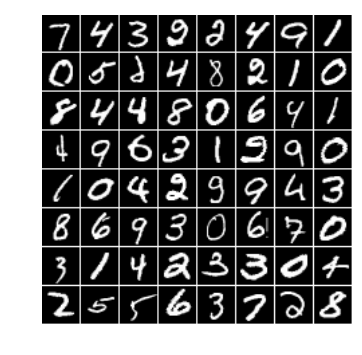

In [6]:
trainImgsGrid = train[:, 100:200]

gridDim = 8
imgGridReal = np.ones((29*gridDim, 29*gridDim))
for i in range(gridDim):
    for j in range(gridDim):
        imgGridReal[i*29:i*29 + 28, j*29:j*29 + 28] = unpackcw(trainImgsGrid[:, gridDim*i + j], 28, 28)
plt.figure(i)
plt.imshow(imgGridReal, cmap='gray')
plt.axis('off');
plt.savefig('mnist_real.png')

# Autoencoder Generated 

In [28]:
squareSideLength = 12
autoencoder_train_pre = np.load('mnist_gan/predictedTrain_square_%d.npy' %squareSideLength)
autoencoder_test_pre = np.load('mnist_gan/predictedTest_square_%d.npy' %squareSideLength)

print autoencoder_train_pre.shape
print autoencoder_test_pre.shape

(784, 55000)
(784, 10000)


In [29]:
maskVec = generateCenterSquareMask(squareSideLength)
x_idx = np.where([maskVec == 1])[1]
y_idx = np.where([maskVec == 0])[1]

ae_train = np.copy(train)
ae_train[y_idx] = autoencoder_train_pre[y_idx]
ae_test = np.copy(test)
ae_test[y_idx] = autoencoder_test_pre[y_idx]

print ae_train.shape
print ae_test.shape

(784, 55000)
(784, 10000)


# Affine Estimator - Center Squares

In [30]:
squareSideLength = 12
train_hideCenter, Xtrain_hideCenter, Ytrain_hideCenter, \
test_hideCenter, Xtest_hideCenter, Ytest_hideCenter = returnSquareData(squareSideLength)

# u_x, u_y, cov_x, cov_yx = getStatistics(train, generateCenterSquareMask(squareSideLength))

# def Wstar(cov_x, cov_yx):
#     if cov_x.any():
#         cov_x_inv = np.linalg.pinv(cov_x)
#     else:
#         cov_x_inv = cov_x
#     W = np.dot(cov_yx, cov_x_inv)
#     return W

# def mmseEstimator(x, u_x, u_y, cov_x, cov_yx):
#     W = Wstar(cov_x, cov_yx)
#     dist = x - u_x.reshape((u_x.shape[0]), 1)
#     return np.dot(W, dist) + u_y.reshape((u_y.shape[0]), 1)

# Ytrain_hat = mmseEstimator(Xtrain_hideCenter, u_x, u_y, cov_x, cov_yx)
# Ytest_hat = mmseEstimator(Xtest_hideCenter, u_x, u_y, cov_x, cov_yx)

# maskVec = generateCenterSquareMask(squareSideLength)
# x_idx = np.where([maskVec == 1])[1]
# y_idx = np.where([maskVec == 0])[1]

# approxImgVecs_train = np.zeros((train.shape[0], train.shape[1]))
# approxImgVecs_test = np.zeros((test.shape[0], test.shape[1]))
# approxImgVecs_train[x_idx, :] = Xtrain_hideCenter
# approxImgVecs_train[y_idx, :] = Ytrain_hat
# approxImgVecs_test[x_idx, :] = Xtest_hideCenter
# approxImgVecs_test[y_idx, :] = Ytest_hat

# np.save('mnist_gan/affine_train_squares_%d.npy' %squareSideLength, approxImgVecs_train)
# np.save('mnist_gan/affine_test_squares_%d.npy' %squareSideLength, approxImgVecs_test)

approxImgVecs_train = np.load('mnist_gan/affine_train_squares_%d.npy' %squareSideLength)
approxImgVecs_test = np.load('mnist_gan/affine_test_squares_%d.npy' %squareSideLength)

Ytrain_hat = approxImgVecs_train[y_idx]
Ytest_hat = approxImgVecs_test[y_idx]

# calculate the mse of the training and test sets using affine estimator
# this is only on the regenerated center
diff_train = Ytrain_hat - Ytrain_hideCenter
trainMSEs = np.zeros(55000)
for i in range(55000):
    trainMSEs[i] = np.mean(np.multiply(diff_train[:, i], diff_train[:, i]))
trainMSE = np.mean(trainMSEs)

diff_test = Ytest_hat - Ytest_hideCenter
testMSEs = np.zeros(10000)
for i in range(10000):
    testMSEs[i] = np.mean(np.multiply(diff_test[:, i], diff_test[:, i]))
testMSE = np.mean(testMSEs)

print '---- Affine Estimator MSE ----'
print 'Train data: %f' %trainMSE
print 'Test data: %f' %testMSE

----MNIST dataset loaded----
Train data: 784 x 55000
Test data: 784 x 10000
---- Affine Estimator MSE ----
Train data: 0.098851
Test data: 0.101168


# GAN + Gradient Descent

In [31]:
squareSideLength = 12
hiddenImgs = np.load('mnist_gan/hiddenImgs_%d_mnist_test.npy' %squareSideLength).T
generatedImgs = np.load('mnist_gan/generatedImgs_%d_mnist_test.npy' %squareSideLength).T
reconstructedImgs = np.load('mnist_gan/reconstructedImgs_%d_mnist_test.npy' %squareSideLength).T
l2_gan = np.load('mnist_gan/L2_loss_bs100_%d_mnist_test.npy' %squareSideLength).T

print hiddenImgs.shape
print generatedImgs.shape
print reconstructedImgs.shape
print l2_gan.shape
print np.mean(l2_gan)

(784, 10000)
(784, 10000)
(784, 10000)
(100,)
0.174008446336


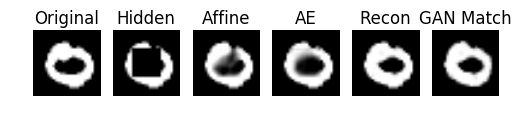

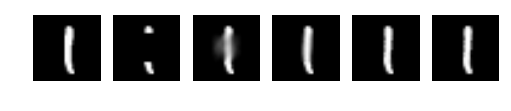

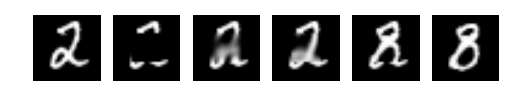

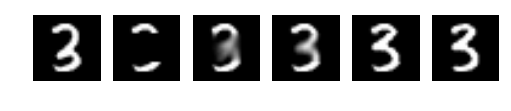

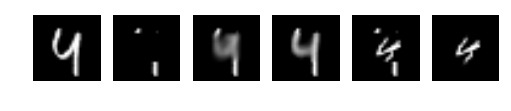

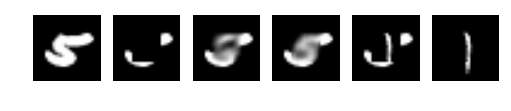

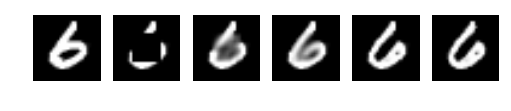

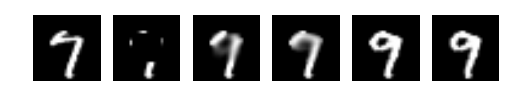

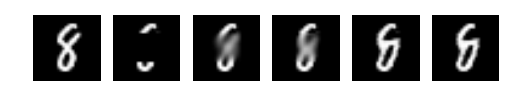

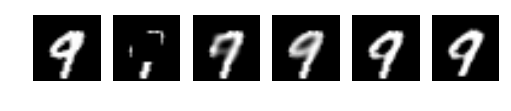

In [63]:
gridDimX = 5
gridDimY = 10
whiteSpace = 5
imgsToGrid = np.zeros((gridDimY*gridDimX, 28, 28))

for i in range(10):  
    idxs_num = np.where(test_labels==i)[0]
    idx_num = np.random.randint(0, len(idxs_num))
    idx = idxs_num[idx_num]

    origVec = test[:, idx]
    hiddenVec = hiddenImgs[:, idx]
    genVec = generatedImgs[:, idx]
    reconVec = np.clip(reconstructedImgs[:, idx], 0.0, 1.0)
    affineVec = np.clip(approxImgVecs_test[:, idx], 0.0, 1.0)
    aeVec = np.clip(ae_test[:, idx], 0.0, 1.0)
    
    origImg = unpackcw(origVec, 28, 28)
    hiddenImg = unpackcw(hiddenVec, 28, 28)
    genImg = unpackcw(genVec, 28, 28)
    reconImg = unpackcw(reconVec, 28, 28)
    affineImg = unpackcw(affineVec, 28, 28)
    aeImg = unpackcw(aeVec, 28, 28)
    
    imgsToGrid[i*gridDimX] = origImg
    imgsToGrid[i*gridDimX + 1] = hiddenImg
    imgsToGrid[i*gridDimX + 2] = affineImg
    imgsToGrid[i*gridDimX + 3] = aeImg
    imgsToGrid[i*gridDimX + 4] = reconImg

    plt.figure(i);
    if (i==0):
        plt.subplot(1, 6, 1); plt.imshow(origImg, cmap='gray'); plt.title('Original'); plt.axis('off')
        plt.subplot(1, 6, 2); plt.imshow(hiddenImg, cmap='gray'); plt.title('Hidden'); plt.axis('off')
        plt.subplot(1, 6, 3); plt.imshow(affineImg, cmap='gray'); plt.title('Affine'); plt.axis('off')
        plt.subplot(1, 6, 4); plt.imshow(aeImg, cmap='gray'); plt.title('AE'); plt.axis('off')
        plt.subplot(1, 6, 5); plt.imshow(reconImg, cmap='gray'); plt.title('Recon'); plt.axis('off')
        plt.subplot(1, 6, 6); plt.imshow(genImg, cmap='gray'); plt.title('GAN Match'); plt.axis('off')
    else:
        plt.subplot(1, 6, 1); plt.imshow(origImg, cmap='gray'); plt.axis('off')
        plt.subplot(1, 6, 2); plt.imshow(hiddenImg, cmap='gray'); plt.axis('off')
        plt.subplot(1, 6, 3); plt.imshow(affineImg, cmap='gray'); plt.axis('off')
        plt.subplot(1, 6, 4); plt.imshow(aeImg, cmap='gray'); plt.axis('off')
        plt.subplot(1, 6, 5); plt.imshow(reconImg, cmap='gray'); plt.axis('off')
        plt.subplot(1, 6, 6); plt.imshow(genImg, cmap='gray'); plt.axis('off')


imgGridTest = np.ones(((28+whiteSpace)*gridDimY, (28+whiteSpace)*gridDimX))
for i in range(gridDimY):
    for j in range(gridDimX):
        imgGridTest[i*(28+whiteSpace):i*(28+whiteSpace) + 28, \
                j*(28+whiteSpace):j*(28+whiteSpace) + 28] \
        = imgsToGrid[i*gridDimX + j]


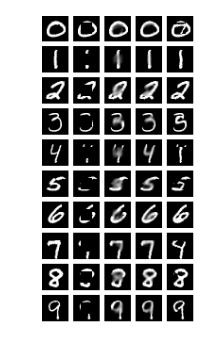

In [61]:
plt.figure()
plt.imshow(imgGridTest, cmap='gray')
plt.axis('off');
plt.savefig('gan_sampleCompletions_%d_2.png' %squareSideLength, dpi=2000)

# Make images in a grid, easier to generate figures

In [ ]:
imgsToGrid = np.copy(train[:, :100])
imgGrid = np.ones((29*10, 29*10))
for i in range(10):
    for j in range(10):
        imgGrid[i*29:i*29 + 28, j*29:j*29 + 28] = unpackcw(imgsToGrid[:, 10*i + j], 28, 28)

In [ ]:
plt.figure(i)
plt.imshow(imgGrid, cmap='gray')
plt.axis('off');
plt.savefig('temp.eps', format='eps', dpi=1000)

In [ ]:
squareSideLength = 10
hiddenImgs = np.load('tmp/hiddenImgs_%d_mnist_test.npy' %squareSideLength).T
generatedImgs = np.load('tmp/generatedImgs_%d_mnist_test.npy' %squareSideLength).T
reconstructedImgs = np.load('tmp/reconstructedImgs_%d_mnist_test.npy' %squareSideLength).T
l2_gan = np.load('tmp/L2_loss_bs100_%d_mnist_test.npy' %squareSideLength).T

print hiddenImgs.shape
print generatedImgs.shape
print reconstructedImgs.shape
print l2_gan.shape
print np.mean(l2_gan)

In [ ]:
for i in range(20):
    idx = np.random.randint(0, 100)
    
    origReallyVec = test[:, idx]
    origVec = hiddenImgs[:, idx]
    hiddenVec = generatedImgs[:, idx]
    genVec = reconstructedImgs[:, idx]
    
    origReallyImg = unpackcw(origReallyVec, 28, 28)
    origImg = unpackcw(origVec, 28, 28)
    hiddenImg = unpackcw(hiddenVec, 28, 28)
    genImg = unpackcw(genVec, 28, 28)
    
    plt.figure(i);
    if (i==0):
        plt.subplot(1, 4, 1); plt.imshow(origReallyImg, cmap='gray'); plt.title('Original'); plt.axis('off')
        plt.subplot(1, 4, 2); plt.imshow(origImg, cmap='gray'); plt.title('Hidden'); plt.axis('off')
        plt.subplot(1, 4, 3); plt.imshow(hiddenImg, cmap='gray'); plt.title('GAN Match'); plt.axis('off')
        plt.subplot(1, 4, 4); plt.imshow(genImg, cmap='gray'); plt.title('Recon'); plt.axis('off')
    else:
        plt.subplot(1, 4, 1); plt.imshow(origReallyImg, cmap='gray'); plt.axis('off')
        plt.subplot(1, 4, 2); plt.imshow(origImg, cmap='gray'); plt.axis('off')
        plt.subplot(1, 4, 3); plt.imshow(hiddenImg, cmap='gray'); plt.axis('off')
        plt.subplot(1, 4, 4); plt.imshow(genImg, cmap='gray'); plt.axis('off')
